article source is 

[article](https://arxiv.org/abs/2208.05906)

[Moosavian-2017](https://arxiv.org/abs/1711.04006)

[Moosavian-2019](https://arxiv.org/abs/1911.03505)

Our main objective is to simulate the lattice GN model in the staggered formulation

as in equations `A1 and A2` of the article

$
C = 
\begin{bmatrix}
0 & 1 \\
0 & 0 
\end{bmatrix} 
$ 

$
Cdag = 
\begin{bmatrix}
0 & 0 \\
1 & 0 
\end{bmatrix} 
$


$$
H_0 = i \sum_{x=1}^{L-N} -\sigma^+(x)\sigma^-(x+N) + \sigma^-(x)\sigma^+(x+N)
$$

For interaction term we have 

$$
H_G = \frac{G^2}{2} \sum_{x=1,1+N,\dots}^{L-N} \sum_{a=0}^{N-1} \sum_{b=0\\b>a}^{N-1} \sigma^+(x+a)\sigma^-(x+a) \times \sigma^+(x+b)\sigma^-(x+b)
$$

For mass term we have 

$$
M_s = m\sum_{x=1}^{L}\eta(x)\sigma^+(x)\sigma^-(x)
$$

in this equation $\eta(x)$ changes for each lattice cell, not lattice site

expansion of $H_{G}$

### DMRG function in ITensor

In [1]:
using ITensors 
using Plots

In [2]:
function GN_staggered(L::Integer, N::Integer,G²::Float64,m::Float64,BD::Integer,sw::Integer)
    # L : number of sites
    # N : number of flavor
    # SiteType : 
    # BD : Bond Dimension
    # sw : number sweep
    # err : maxcut
    sites = siteinds("Fermion",L)
    ampoₛ = OpSum()
    ampoₗ = OpSum()
    
    # smaller lattice 
    # H₀ 
    for j in 1:N:(L-1)-N
        ampoₛ -= 1im,"C",j,"Cdag",j+N
        ampoₛ += 1im,"C",j+N,"Cdag",j
    end
#     # Hₘ
#     if N == 1
#         for j in 1:(L-1)
#             ampoₛ += (((-1)^j)*m),"C*Cdag",j
#         end
#     elseif N ==2 
#             for j in 1:(L-1)
#                 if j%4==0 || j%4==3
#                     ampoₛ += m,"C*Cdag",j          
#                 else
#                     ampoₛ -= m,"C*Cdag",j
#                 end
#             end
#     end
    # Hₘ
    
#     # H_g 
    for j in 1:N:(L-1)-N
        ampoₛ += G²/2.,"C*Cdag",j,"C*Cdag",j+1
    end
    ψ₀ₛ = randomMPS(sites[1:L-1],BD)
    Hₛ = MPO(ampoₛ,sites[1:L-1])
    
    
    ##############
    # larger lattice
    # H₀ 
    for j in 1:N:L-N
        ampoₗ -= 1im,"C",j,"Cdag",j+N
        ampoₗ += 1im,"C",j+N,"Cdag",j
    end
#     # Hₘ
    if N == 1
        for j in 1:L
            ampoₗ += (((-1)^j)*m),"C*Cdag",j
        end
    elseif N ==2 
            for j in 1:L                          ## Change 
                if j%4==0 || j%4==3
                    ampoₗ += m,"C*Cdag",j          
                else
                    ampoₗ -= m,"C*Cdag",j
                end
            end
    end
#     # H_g 
    for j in 1:N:L-N
        ampoₗ += G²/2.,"C*Cdag",j,"C*Cdag",j+1
    end
    ψ₀ₗ = randomMPS(sites,BD)
    Hₗ = MPO(ampoₗ,sites)

    sweep = Sweeps(sw)   # increase to stop by err 
    setmaxdim!(sweep,repeat([10],sw)...)
    setcutoff!(sweep,1E-8)
    eₛ, ψₛ = dmrg(Hₛ,ψ₀ₛ,sweep);
    eₗ, ψₗ = dmrg(Hₗ,ψ₀ₗ,sweep);
    
    
    #  Overlap computation
    t1 = ITensor(sites[L])
    for j in 1:Int(size(t1)[1])
        t1[j] = 1.0/sqrt(2.0)
    end
    v = ITensor(1.0)
    lm1 = length(ψₛ)
    lm2 = length(ψₗ)
    for j in 1:L
        if j <= (L-1)
            v = v*dag(ψₛ[j])*ψₗ[j]
        else
            v = v*t1*ψₗ[j]
        end
    end
    return inner(v,v), norm(v)
    
end

GN_staggered (generic function with 1 method)

In [7]:
a,b = GN_staggered(6,1,1.0,0.4,10,3)

After sweep 1 energy=-2.961295665279 maxlinkdim=4 maxerr=2.83E-17 time=0.017
After sweep 2 energy=-2.967495269870 maxlinkdim=4 maxerr=1.35E-16 time=0.017
After sweep 3 energy=-2.967713784671 maxlinkdim=4 maxerr=1.52E-16 time=0.016
After sweep 1 energy=-3.518408042835 maxlinkdim=8 maxerr=1.19E-15 time=0.026
After sweep 2 energy=-3.518598079025 maxlinkdim=8 maxerr=1.27E-16 time=0.035
After sweep 3 energy=-3.518598089783 maxlinkdim=8 maxerr=2.74E-16 time=0.056


(0.35402275135158257 + 0.0im, 0.5949981103764805)

In [8]:
sqrt(a)

0.5949981103764805 + 0.0im

In [4]:
# L::Integer, N::Integer,G²::Float64,m::Float64,BD::Integer,sw::Integer
result = Vector{ComplexF64}()

for j in 3:10
    res , norm_res = GN_staggered(j,1,1.5,0.2,10,3); # change BD --> 100
    push!(result, res);
    push!()
end    

After sweep 1 energy=-1.019761067302 maxlinkdim=2 maxerr=0.00E+00 time=2.078
After sweep 2 energy=-1.019803902676 maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 3 energy=-1.019803902719 maxlinkdim=2 maxerr=0.00E+00 time=0.001
After sweep 1 energy=-1.391719007723 maxlinkdim=2 maxerr=6.34E-17 time=0.002
After sweep 2 energy=-1.422648577893 maxlinkdim=2 maxerr=9.99E-16 time=0.003
After sweep 3 energy=-1.427707726117 maxlinkdim=2 maxerr=1.22E-15 time=0.003
After sweep 1 energy=-1.420669363473 maxlinkdim=2 maxerr=1.11E-15 time=0.003
After sweep 2 energy=-1.427899813644 maxlinkdim=2 maxerr=1.22E-15 time=0.004
After sweep 3 energy=-1.428267171602 maxlinkdim=2 maxerr=1.50E-15 time=0.004
After sweep 1 energy=-2.097989445770 maxlinkdim=4 maxerr=1.60E-16 time=0.004
After sweep 2 energy=-2.098133641899 maxlinkdim=4 maxerr=6.99E-17 time=0.005
After sweep 3 energy=-2.098133657189 maxlinkdim=4 maxerr=0.00E+00 time=0.007
After sweep 1 energy=-2.096899776668 maxlinkdim=4 maxerr=1.55E-16 time=0.007

After sweep 2 energy=-11.187533512295 maxlinkdim=10 maxerr=1.23E-05 time=0.047
After sweep 3 energy=-11.188295412983 maxlinkdim=10 maxerr=1.33E-05 time=0.033
After sweep 1 energy=-11.133827634092 maxlinkdim=10 maxerr=1.50E-03 time=0.032
After sweep 2 energy=-11.183939764633 maxlinkdim=10 maxerr=1.10E-05 time=0.046
After sweep 3 energy=-11.188186236682 maxlinkdim=10 maxerr=1.37E-05 time=0.040
After sweep 1 energy=-11.745854999868 maxlinkdim=10 maxerr=1.54E-03 time=0.036
After sweep 2 energy=-11.786646695243 maxlinkdim=10 maxerr=2.30E-05 time=0.055
After sweep 3 energy=-11.787353317732 maxlinkdim=10 maxerr=1.88E-05 time=0.033
After sweep 1 energy=-11.775362136368 maxlinkdim=10 maxerr=1.26E-03 time=0.035
After sweep 2 energy=-11.787303666242 maxlinkdim=10 maxerr=1.72E-05 time=0.049
After sweep 3 energy=-11.787358115798 maxlinkdim=10 maxerr=1.52E-05 time=0.033
After sweep 1 energy=-12.292058047357 maxlinkdim=10 maxerr=1.32E-03 time=0.040
After sweep 2 energy=-12.306779044638 maxlinkdim=10 

After sweep 1 energy=-20.871118618239 maxlinkdim=10 maxerr=2.31E-03 time=0.079
After sweep 2 energy=-20.903996128238 maxlinkdim=10 maxerr=3.74E-05 time=0.087
After sweep 3 energy=-20.905312373700 maxlinkdim=10 maxerr=4.12E-05 time=0.090
After sweep 1 energy=-21.388843269272 maxlinkdim=10 maxerr=2.06E-03 time=0.068
After sweep 2 energy=-21.437655283562 maxlinkdim=10 maxerr=2.14E-05 time=0.074
After sweep 3 energy=-21.440682637971 maxlinkdim=10 maxerr=3.69E-05 time=0.075
After sweep 1 energy=-21.342634956002 maxlinkdim=10 maxerr=2.17E-03 time=0.065
After sweep 2 energy=-21.438132119609 maxlinkdim=10 maxerr=2.50E-05 time=0.085
After sweep 3 energy=-21.441658833411 maxlinkdim=10 maxerr=4.13E-05 time=0.082
After sweep 1 energy=-22.004897095312 maxlinkdim=10 maxerr=2.09E-03 time=0.091
After sweep 2 energy=-22.041087389999 maxlinkdim=10 maxerr=4.04E-05 time=0.094
After sweep 3 energy=-22.042999657348 maxlinkdim=10 maxerr=5.77E-05 time=0.085
After sweep 1 energy=-22.001839533507 maxlinkdim=10 

After sweep 3 energy=-30.567965780008 maxlinkdim=10 maxerr=5.21E-05 time=0.098
After sweep 1 energy=-30.996764321483 maxlinkdim=10 maxerr=2.27E-03 time=0.099
After sweep 2 energy=-31.139456477292 maxlinkdim=10 maxerr=3.61E-05 time=0.099
After sweep 3 energy=-31.151900019495 maxlinkdim=10 maxerr=4.49E-05 time=0.098
After sweep 1 energy=-31.109229586461 maxlinkdim=10 maxerr=2.17E-03 time=0.104
After sweep 2 energy=-31.146738648122 maxlinkdim=10 maxerr=2.28E-05 time=0.099
After sweep 3 energy=-31.153186736817 maxlinkdim=10 maxerr=4.86E-05 time=0.099
After sweep 1 energy=-31.578266114714 maxlinkdim=10 maxerr=3.14E-03 time=0.098
After sweep 2 energy=-31.696629337106 maxlinkdim=10 maxerr=2.62E-05 time=0.099
After sweep 3 energy=-31.711984234940 maxlinkdim=10 maxerr=5.45E-05 time=0.092
After sweep 1 energy=-31.657284199031 maxlinkdim=10 maxerr=2.46E-03 time=0.110
After sweep 2 energy=-31.707715287624 maxlinkdim=10 maxerr=2.90E-05 time=0.090
After sweep 3 energy=-31.713344761013 maxlinkdim=10 

After sweep 2 energy=-40.815826490313 maxlinkdim=10 maxerr=2.32E-05 time=0.138
After sweep 3 energy=-40.828056548128 maxlinkdim=10 maxerr=5.12E-05 time=0.130
After sweep 1 energy=-40.738379795829 maxlinkdim=10 maxerr=2.45E-03 time=0.142
After sweep 2 energy=-40.823076269608 maxlinkdim=10 maxerr=3.58E-05 time=0.175
After sweep 3 energy=-40.829224374766 maxlinkdim=10 maxerr=5.94E-05 time=0.162
After sweep 1 energy=-41.313017098174 maxlinkdim=10 maxerr=2.59E-03 time=0.133
After sweep 2 energy=-41.404314679993 maxlinkdim=10 maxerr=2.24E-05 time=0.137
After sweep 3 energy=-41.406400369351 maxlinkdim=10 maxerr=3.38E-05 time=0.131
After sweep 1 energy=-41.285794355919 maxlinkdim=10 maxerr=2.54E-03 time=0.138
After sweep 2 energy=-41.392974912892 maxlinkdim=10 maxerr=4.52E-05 time=0.157
After sweep 3 energy=-41.405484441291 maxlinkdim=10 maxerr=4.71E-05 time=0.140
After sweep 1 energy=-41.873857687184 maxlinkdim=10 maxerr=2.05E-03 time=0.135
After sweep 2 energy=-41.959413049039 maxlinkdim=10 

After sweep 1 energy=-50.415438891069 maxlinkdim=10 maxerr=2.22E-03 time=0.403
After sweep 2 energy=-50.524154211170 maxlinkdim=10 maxerr=3.47E-05 time=0.388
After sweep 3 energy=-50.526743771999 maxlinkdim=10 maxerr=3.53E-05 time=0.286
After sweep 1 energy=-50.983225073603 maxlinkdim=10 maxerr=2.85E-03 time=0.328
After sweep 2 energy=-51.074009009072 maxlinkdim=10 maxerr=3.77E-05 time=0.318
After sweep 3 energy=-51.081481457141 maxlinkdim=10 maxerr=3.74E-05 time=0.411
After sweep 1 energy=-50.985139928926 maxlinkdim=10 maxerr=2.70E-03 time=0.443
After sweep 2 energy=-51.079579832606 maxlinkdim=10 maxerr=3.15E-05 time=0.375
After sweep 3 energy=-51.082772184414 maxlinkdim=10 maxerr=3.87E-05 time=0.329
After sweep 1 energy=-51.575212220498 maxlinkdim=10 maxerr=2.00E-03 time=0.264
After sweep 2 energy=-51.664129344635 maxlinkdim=10 maxerr=2.60E-05 time=0.252
After sweep 3 energy=-51.668033537219 maxlinkdim=10 maxerr=3.76E-05 time=0.213
After sweep 1 energy=-51.534135050561 maxlinkdim=10 

In [5]:
length(result)

98

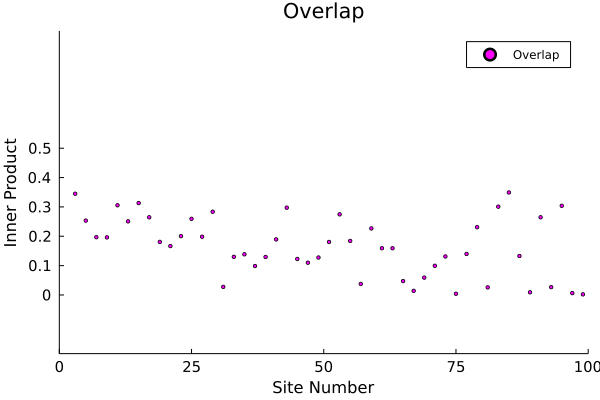

In [6]:
site_number = [x for x in 2:9]
# gr()
result = real(result)
theme(:wong)
# theme(:dark)
# theme(:ggplot2)

scatter(site_number[2:2:9],result[1:2:98],
        label = "Overlap",
        grid=false,
        dpi = 7000,
        xlim=(0,100),
        ylim=(-0.2,0.9),
        xticks=((0:25:100),["0","25","50","75","100"]),
        yticks=((0:0.1:0.5), ["0","0.1","0.2","0.3","0.4","0.5"]),
        xlabel="Site Number",
        ylabel="Inner Product",
        title="Overlap",
#         color = :fuchsia,
#         color = :lightseagreen,
#         color = :magenta,
        marker=:circle,
        markercolor=:fuchsia,
        markersize=2,
        alpha = 1,
        tickfontsize=10)


function partial_inner(ψ₁, ψ₂)
  n1 = length(ψ₁)
  n2 = length(ψ₂)
  @assert n1 < n2
  o = ITensor(1.0)
  for j in 1:n2
    if j <= n1
      o = o * dag(ψ₁[j]) * ψ₂[j]
    else
      o = o * ψ₂[j]
    end
  end
  return o
end

# Draft

In [4]:
floor(15/2)

7.0